In [1]:
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import urllib.request
import zipfile
import os

In [2]:
def loadData(path):
    df = pd.read_csv(path, encoding = 'latin1')
    return df
oes = loadData(path = "./data/preprocessed/oes.csv")
nat = loadData(path = "./data/preprocessed/nat.csv")
occ = loadData(path = "./data/preprocessed/natocc2017.csv")
oes2017 = loadData(path = "./data/preprocessed/oes2017all.csv")

In [3]:
def compareData(df, on, idx):
    df2008 = (df[(df.YEAR == 2008)]
               .rename(columns = {'A_MEDIAN': 'A_MEDIAN_2008',
                                  'JOBS_1000': 'JOBS_1000_2008',
                                  'TOT_EMP': 'TOT_EMP_2008'}))

    df2017 = (df[(df.YEAR == 2017)]
               .rename(columns = {'A_MEDIAN': 'A_MEDIAN_2017',
                                  'JOBS_1000': 'JOBS_1000_2017',
                                  'TOT_EMP': 'TOT_EMP_2017'}))

    compare = pd.merge(left = df2008, right = df2017, how = 'left', on = on)
    compare = (compare
               .assign(SALARY_PCT_GROWTH = lambda x: (x.A_MEDIAN_2017 - x.A_MEDIAN_2008) / x.A_MEDIAN_2008 * 100,
                       JOB_PCT_GROWTH = lambda x: (x.TOT_EMP_2017 - x.TOT_EMP_2008) / x.TOT_EMP_2008 * 100))
    compare = compare.set_index(idx)
    return compare
marketComparison = compareData(oes, ['AREA', 'Market'], 'Market')              
industryComparison = compareData(nat, ['NAICS', 'Industry'], 'Industry')

In [47]:
def plotBar(ax, df, ci, xvar, yvar, xlab, ylab, title):
    barwidth = .8
    sns.set_style("whitegrid")
    x = np.arange(df.shape[0]) * 1.08
    y = df[yvar]
    ax = sns.barplot(x=xvar, y=yvar, data=df, palette = "viridis", hue = xvar, ax = ax)    
    ax.set(xticklabels=[])
    ax.set(xlabel = xlab, ylabel = ylab)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
    for patch in ax.patches:
        patch.set_width(barwidth)
    ax.set_title(label = title)
    ax.set_xlim((-.7,10.5))
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.title.set(y = 1.45)
    ax.errorbar(x, y, yerr = ci)
    return(ax)
    #plt.show()

In [48]:
def plotViolin(ax, df, xvar, yvar, xlab, ylab, title):
    sns.set_style("whitegrid")
    ax = sns.violinplot(x=xvar, y=yvar, data = df, hue=xvar, palette='viridis', ax = ax)
    ax.set(xticklabels=[])
    ax.set(xlabel = xlab, ylabel = ylab)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
    ax.set(title = title)
    ax.title.set(y = 1.45)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    return (ax)
    #plt.show()

In [49]:
def plotTopGrowth(ax, df, size, title):
    # Obtain data for appropriate data set and employment market size
    cols = ['TOT_EMP_2008', 'TOT_EMP_2017']
    n = (df.shape[0])
    topGrowth = (df
                 .nlargest(int(n * size / 3), columns = 'TOT_EMP_2017')
                 .nlargest(5, columns = 'JOB_PCT_GROWTH')
                 .drop(df.columns.difference(cols), axis = 1, inplace = False)
                 .apply(pd.to_numeric, errors = 'ignore')
                 .rename(columns = {'TOT_EMP_2008': '2008',
                                    'TOT_EMP_2017': '2017'})
                 .transpose())
    ax = topGrowth.plot(topGrowth.index.name, topGrowth.columns, title = title, ax=ax)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    #ax.legend(loc='upper left')
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
    ax.title.set(y = 1.45)
    return(ax)

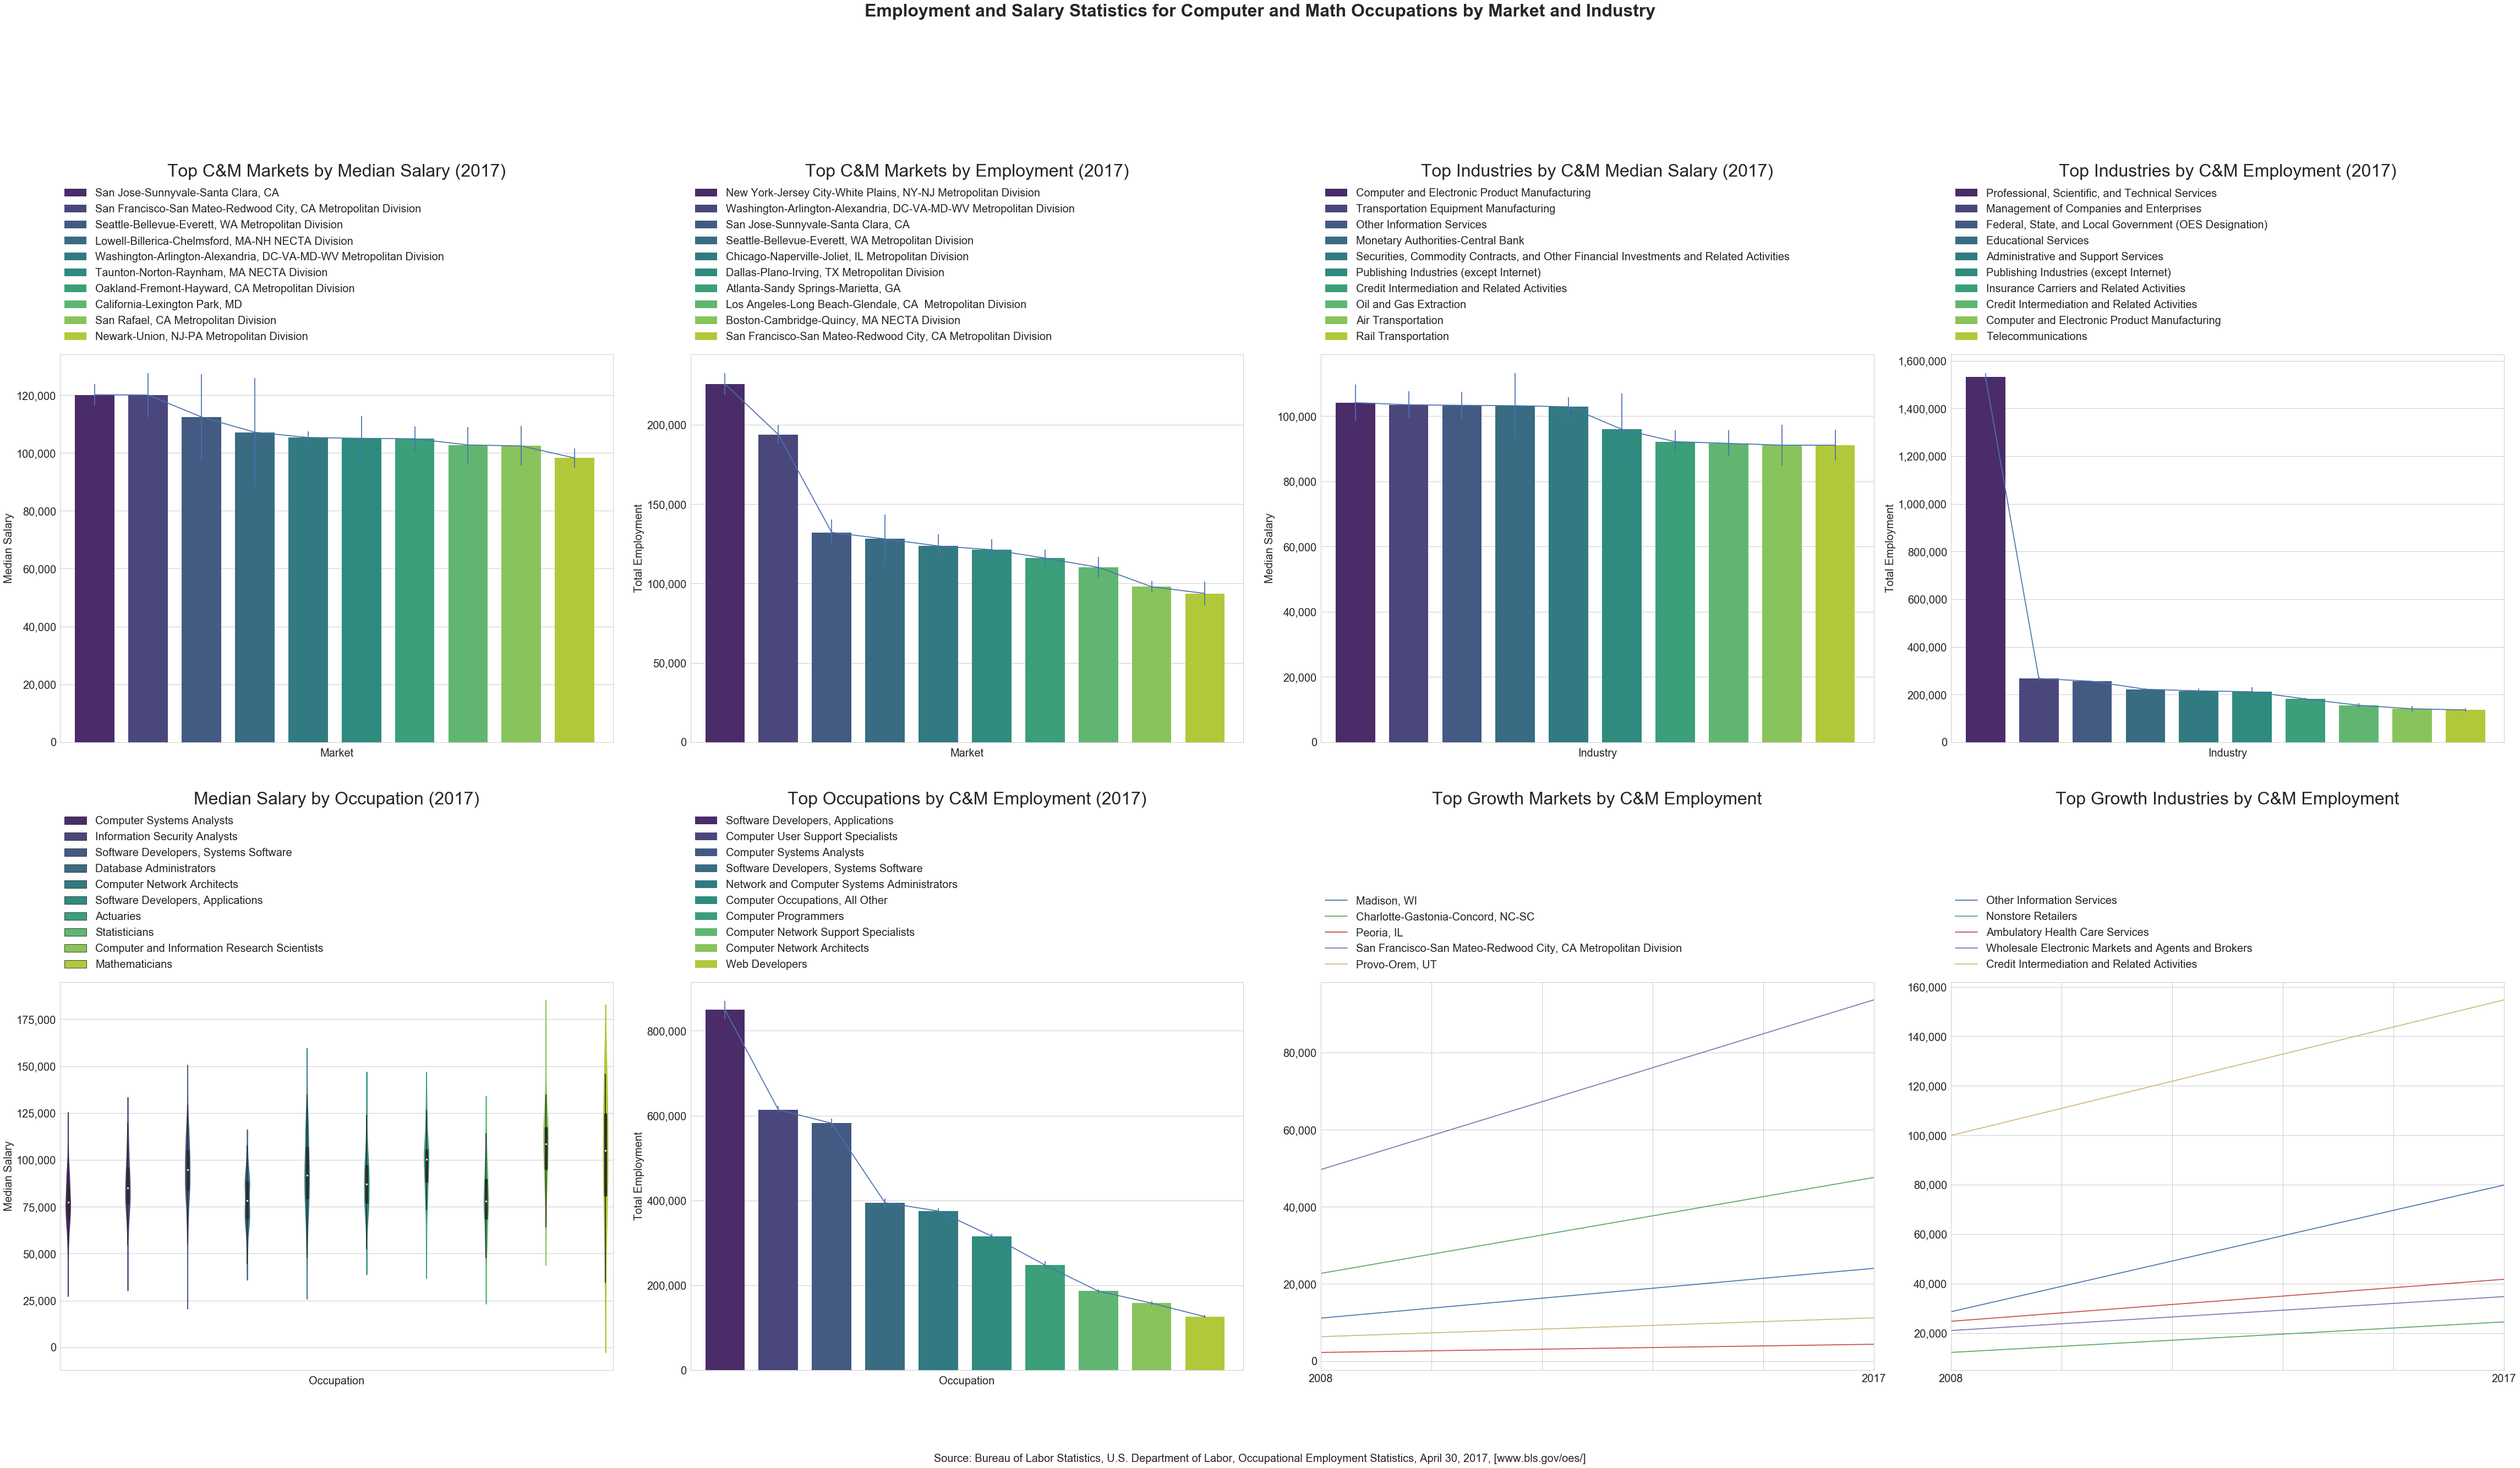

In [56]:
def plots():    
    # Obtain figure and axes objects.
    plt.clf()
    fig, ax = plt.subplots(2,4, figsize = (64,32))
    fig.suptitle('Employment and Salary Statistics for Computer and Math Occupations by Market and Industry', 
                 fontsize=32, y=1.1, fontweight='bold')

    # Top markets by median salary
    topSalary = (oes[(oes.YEAR == 2017)][['Market', 'A_MEDIAN', 'A_MEDIAN_ME']].nlargest(n = 10, columns = 'A_MEDIAN'))
    plotBar(ax[0,0], topSalary, topSalary['A_MEDIAN_ME'], "Market", "A_MEDIAN",  "Market", "Median Salary", "Top C&M Markets by Median Salary (2017)")
            
    # Top markets by employment
    topJobs = (oes[(oes.YEAR == 2017)][['Market', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(ax[0,1], topJobs, topJobs['TOT_EMP_ME'],"Market", "TOT_EMP",  "Market", "Total Employment", "Top C&M Markets by Employment (2017)")  
    
    # Top industries by median salary
    topSalary = (nat[(nat.YEAR == 2017)][['Industry', 'A_MEDIAN', 'A_MEDIAN_ME']].nlargest(n = 10, columns = 'A_MEDIAN'))
    plotBar(ax[0,2], topSalary, topSalary['A_MEDIAN_ME'], "Industry", "A_MEDIAN",  "Industry", "Median Salary", "Top Industries by C&M Median Salary (2017)")
    
    # Top industries by employment
    topJobs = (nat[(nat.YEAR == 2017)][['Industry', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(ax[0,3], topJobs, topJobs['TOT_EMP_ME'], "Industry", "TOT_EMP",  "Industry", "Total Employment", "Top Industries by C&M Employment (2017)") 
    
    # Median salaries by occupation (violin)
    topOcc = oes2017.groupby('Occupation')['A_MEDIAN'].agg('mean').nlargest(n=10).reset_index()
    topOcc = pd.merge(oes2017, topOcc, on = 'Occupation')
    plotViolin(ax[1,0], topOcc, "Occupation", "A_MEDIAN_x",  "Occupation", "Median Salary", "Median Salary by Occupation (2017)")    
    
    # Top occupations by employment 
    topJobs = (occ[['Occupation', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(ax[1,1], topJobs, topJobs['TOT_EMP_ME'], "Occupation", "TOT_EMP",  "Occupation", "Total Employment", "Top Occupations by C&M Employment (2017)") 
    
    # Growth plots
    plotTopGrowth(ax[1,2], marketComparison, size = 1, title = "Top Growth Markets by C&M Employment")
    plotTopGrowth(ax[1,3], industryComparison, size = 1, title = "Top Growth Industries by C&M Employment")
    
    # Caption
    cite = 'Source: Bureau of Labor Statistics, U.S. Department of Labor, Occupational Employment Statistics, April 30, 2017, [www.bls.gov/oes/]'
    fig.text(.5, -.05, cite, ha='center')

    # Render plot and png
    fig.tight_layout()
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    LARGE_SIZE = 24
    VLARGE_SIZE = 32

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=VLARGE_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LARGE_SIZE)     # legend fontsize
    plt.rc('figure', titlesize=VLARGE_SIZE)    # fontsize of the figure title
    plt.savefig("plots.png",bbox_inches='tight', dpi=200, orientation='portrait', facecolor='white')
    plt.show()
            
plots()